# Notebook 1 - Set Project Structure

### 1. Setup constants

In [1]:
from constants import *

In [2]:
IMAGE_SIZE = 224

### 2. Imports and notebook setup

In [3]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Printing with markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [4]:
# Default imports
import os
import random
import shutil
from send2trash import send2trash
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
from PIL import Image, ImageOps
import cv2

In [5]:
if os.path.isdir('../skin-cancer-mnist-ham10000'):
    os.rename(src='../skin-cancer-mnist-ham10000', dst=DATA_ORIGINAL_DIR_PATH, src_dir_fd=None, dst_dir_fd=None)
    print('Renamed directory')

### 3. Directories setup & train test split

#### 3.1 Create directories from scratch

In [6]:
# Create directory structure
if os.path.isdir(DATA_PROCESSED_DIR_PATH):
    print('Reseting project directory structure...')
    send2trash(DATA_PROCESSED_DIR_PATH)

print('Building directory structure...')
os.mkdir(DATA_PROCESSED_DIR_PATH)
for split in SPLIT_DIRS:
    os.mkdir(os.path.join(DATA_PROCESSED_DIR_PATH, split))
    for cls in BINARY_CLASSES:
        os.mkdir(os.path.join(DATA_PROCESSED_DIR_PATH, split, cls))
print('Created successfully!')

Reseting project directory structure...
Building directory structure...
Created successfully!


#### 3.2 Train, test, validation split

In [7]:
df = pd.read_csv(os.path.join(DATA_ORIGINAL_DIR_PATH, 'HAM10000_metadata.csv'))
df.set_index('image_id', inplace=True)
df_all_except_mel = df[df['dx'] != 'mel']

In [8]:
df_2019 = pd.read_csv('../ISIC-2019/ISIC_2019_Training_Metadata.csv')
df_2019_target = pd.read_csv('../ISIC-2019/ISIC_2019_Training_GroundTruth.csv', index_col='image')
df_2019_target = df_2019_target.astype(int)
df_2019_target_mel = df_2019_target[df_2019_target['MEL'] == 1]

In [9]:
df_mel = pd.merge(left=df_2019_target_mel, right=df_2019[['image', 'lesion_id']], on='image', how='left')

In [10]:
# Check how many rows have ['lesion_id'] missing
df_mel['lesion_id'].isna().sum()
len(df_mel)

337

4522

In [11]:
# Check if all images in the old ISIC are in the new one
counter = 0
for old_img in df.index.values:
    if old_img in df_2019.image.values:
        counter += 1
print('counter:', '{:,}'.format(counter))
counter == len(df)

counter: 10,015


True

In [12]:
# Check if there is any overlap
df_mel['image'].isin(df_all_except_mel.index).sum()

0

In [13]:
def train_test_split_on_column(df, column_to_split, test_rate=0.15, val_rate=0.15, random_seed=100):
    # Setting random seed for the split
    random.seed(random_seed)
    
    num_of_missing = df[column_to_split].isnull().sum()
    fill_missing_values = ['missing_' + str(x) for x in range(num_of_missing)]
    
    null_indices = df[df[column_to_split].isna()].index
    for i, fill_label in zip(null_indices, fill_missing_values):
        df.loc[i, column_to_split] = fill_label
    
    values = df[column_to_split].unique().tolist()
    
    test_size = round(test_rate * len(values))
    val_size = round(val_rate * len(values))

    test_val_values = random.sample(population=values, k=test_size + val_size)
    test_values = random.sample(population=test_val_values, k=test_size)
    val_values = [x for x in test_val_values if x not in test_values]

    df_train = df[~df[column_to_split].isin(test_val_values)]
    df_test = df[df[column_to_split].isin(test_values)]
    df_val = df[df[column_to_split].isin(val_values)]
    
    return df_train, df_test, df_val

In [14]:
m_df_train, m_df_test, m_df_val = train_test_split_on_column(df_mel, 'lesion_id')
nm_df_train, nm_df_test, nm_df_val = train_test_split_on_column(df_all_except_mel, 'lesion_id')

In [15]:
len(nm_df_train) + len(nm_df_test) + len(nm_df_val) == len(df_all_except_mel)
len(m_df_train) + len(m_df_test) + len(m_df_val) == len(df_mel)

True

True

In [16]:
# Check if the split was stratified
# % difference between train and test
a = 100 * nm_df_train.dx.value_counts() / len(nm_df_train)
b = 100 * nm_df_test.dx.value_counts() / len(nm_df_test)
c = 100 * nm_df_val.dx.value_counts() / len(nm_df_val)

a - b
a - c

nv      -1.843574
bkl      0.600417
bcc      0.475009
akiec    0.804418
vasc    -0.411110
df       0.374840
Name: dx, dtype: float64

nv       1.927868
bkl     -1.057405
bcc      0.090084
akiec   -0.208834
vasc    -0.838740
df       0.087027
Name: dx, dtype: float64

#### 3.3 Copy images to appropriate directory

(224, 224, 3)

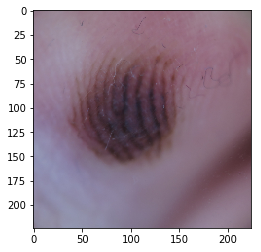

In [10]:
# im_path = os.path.join(NEW_DATA_DIR_PATH, 'ISIC_2019_Training_Input', 'ISIC_0073251.jpg')

# original_img = Image.open(im_path)
# new_img = resize_to_square(original_img, (224, 224))

# new_img = np.asarray(new_img)
# new_img.shape
# Image(new_img)
# plt.imshow(new_img)

In [17]:
def resize_to_square(img, final_shape):
    '''
    Takes a PIL.JpegImagePlugin.JpegImageFile as input
    '''
    desired_size = max(img.size)
    old_size = img.size
    delta_w = desired_size - old_size[0]
    delta_h = desired_size - old_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    new_img = np.asarray(ImageOps.expand(img, padding))
    return cv2.resize(new_img, final_shape)

In [18]:
###########################################################
# TRANSFER IMAGES TO APROPIATE DIRECTORIES
###########################################################

# Data directories
dir_part_1 = os.path.join(DATA_ORIGINAL_DIR_PATH, 'HAM10000_images_part_1')
dir_part_2 = os.path.join(DATA_ORIGINAL_DIR_PATH, 'HAM10000_images_part_2')

# List of images in each part
images_part_1 = os.listdir(dir_part_1)
images_part_2 = os.listdir(dir_part_2)

# List in trainning and test data splits
nm_train_images = nm_df_train.index.unique()
nm_test_images = nm_df_test.index.unique()
nm_val_images = nm_df_val.index.unique()

for split, images in zip(SPLIT_DIRS, [nm_train_images, nm_test_images, nm_val_images]):
    for img in images:
        img_name = img + '.' + IMG_FORMAT
        img_diagnosis = 'other'

        origin = os.path.join(dir_part_1 if img_name in images_part_1 else dir_part_2, img_name)
        destiny = os.path.join(DATA_PROCESSED_DIR_PATH, split, img_diagnosis, img_name)
        
        original_img = Image.open(origin)
        processed_img = resize_to_square(original_img, (IMAGE_SIZE, IMAGE_SIZE))
        
        plt.imsave(destiny, processed_img)

In [20]:
# Data directory
dir_part_3 = os.path.join(NEW_DATA_DIR_PATH, 'ISIC_2019_Training_Input')

# List in trainning and test data splits
m_train_images = m_df_train['image'].unique()
m_test_images = m_df_test['image'].unique()
m_val_images = m_df_val['image'].unique()

for split, images in zip(SPLIT_DIRS, [m_train_images, m_test_images, m_val_images]):
    for img in images:
        img_name = img + '.' + IMG_FORMAT
        img_diagnosis = 'mel'

        origin = os.path.join(dir_part_3, img_name)
        destiny = os.path.join(DATA_PROCESSED_DIR_PATH, split, img_diagnosis, img_name)
        
        original_img = Image.open(origin)
        processed_img = resize_to_square(original_img, (IMAGE_SIZE, IMAGE_SIZE))
        
        plt.imsave(destiny, processed_img)

In [21]:
# Check proportion for each class
for i in range(len(SPLIT_DIRS)):
    print(SPLIT_DIRS[i])
    
    for cls in BINARY_CLASSES:
        cls_sizes = [len(os.listdir(os.path.join(DATA_PROCESSED_DIR_PATH, split, cls))) 
                      for split in SPLIT_DIRS]
        print(cls, cls_sizes[i] / sum(cls_sizes) * 100)
    print()

train
other 70.18647494944956
mel 69.04024767801857

test
other 14.816895079757359
mel 16.143299425033174

validation
other 14.99662997079308
mel 14.816452896948254



In [22]:
len(m_df_train)
len(m_df_test)
len(m_df_val)

3122

730

670

In [23]:
len(nm_df_train)
len(nm_df_test)
len(nm_df_val)

6248

1319

1335